# Cluster Analysis of Tweets
## Cluster Analysis Details
Here we are trying to uncover some underlying structure to the tweets we have collected so far. We will first try to perform a cluster analysis to the tweets to see if the tweets will group into clusters that we can exploit when trying to label data. We start by describing the problem:

We are given an input dataset $\mathbf{X} = [x_1, \dots, x_k]$, where $x_i \in \mathbb{R}^d$. We want to find a dictionary $\mathbf{D} \in \mathbb{R}^{d x n}$: $\mathbf{D} = [d_1, \dots, d_n]$ and a representation $\mathbf{R} = [r_1, ..., r_k], r_i \in \mathbb{R}^n$ s.t. both $||\mathbf{X} - \mathbf{DR}||^2_F$ is minimized and the representations $r_i$ are sparse enough. This has the optimization problem:

${argmin}_{D\in C, r_i \in \mathbb{R}^n} \sum_{i=1}^{k} ||x_i - Dr_i||^2_2 + \lambda ||r_i||_0$, where $C \equiv \{D\in \mathbb{R}^{d x n}: ||d_i||_2 \leq 1, \forall i \in 1, \dots, n\}, \lambda >0$

$C$ is required to constrain $\mathbf{D}$ so that its atoms would not reach arbitrarily high values allowing for arbitrarily low (but non-zero) values of $r_{i}$. $\lambda$  controls the trade off between the sparsity and the minimization error. We usually use the $\ell_1$ instead of the $\ell_0$ norm instead in order to maintain convexity of the problem. In this case, we are dealing with an __overcomplete dictionary__ since the dimension of the representations of the strings $n$ is larger than the input data's dimension $d$. An overcomplete dictionary which allows for sparse representation of signal can be a famous transform matrix (wavelets transform, fourier transform) or it can be formulated so that its elements are changed in such a way that it sparsely represents the given signal in a best way. Learned dictionaries are capable of giving sparser solutions as compared to predefined transform matrices.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import glob
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import string
import re
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('punkt')
nltk.download('twitter_samples')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [2]:
# Making a list directory of all the tweets we have collected
files_0 = glob.glob('./datasets/water_tweets/gathered_water/*.csv')
water1_tweets = pd.read_csv('./datasets/water_tweets/water1.csv', encoding = 'ISO-8859-1', delimiter = ',')

# loading JSON files
from pandas.io.json import json_normalize
with open('datasets/water_tweets/gathered_water/water8.json', 'r', encoding="utf-8") as json_file:
    water_json_1 = pd.read_json('datasets/water_tweets/gathered_water/water8.json', typ='object', orient='columns')
    water_json_1 = pd.io.json.json_normalize(water_json_1)
    water_json_1 = water_json_1[['text', 'timestamp']]

with open('datasets/water_tweets/gathered_water/water9_drought.json', 'r', encoding = 'utf-8') as json_file:
    water_json_2 = pd.read_json('datasets/water_tweets/gathered_water/water9_drought.json', typ='object', orient='columns')
    water_json_2 = pd.io.json.json_normalize(water_json_2)
    water_json_2 = water_json_2[['text', 'timestamp']]

water_jsons = pd.concat([water_json_1, water_json_2])
water_jsons.columns = ['text', 'date']
water_jsons['retweet_count'] = np.nan
water_jsons['category'] = np.nan
water_jsons['tweet_id'] = np.nan
water_jsons = water_jsons[['category', 'date', 'text', 'retweet_count', 'tweet_id']]

# Loading uniformly formatted pulled tweets
water_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_0])
water_csvs = pd.concat([water1_tweets, water_csvs, water_jsons])
water_csvs = water_csvs[['category', 'text']]
water_csvs = water_csvs[water_csvs['text'] != 'text']
water_csvs = water_csvs[water_csvs['category'] != 'pcb']
water_csvs = water_csvs[water_csvs['category'] != 'benzene']
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
water_csvs['text'] =  water_csvs['text'].astype(str)
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
water_csvs = water_csvs.iloc[:, 1:]
#all_csvs.columns = ['category', 'date', 'tweet', 'retweet_count', 'tweet_id']
print(len(water_csvs))

water_csvs.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



99205


,category,text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...
2,flash flood,So the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod..."
4,flash flood,"They might not call it a #climatedebate, but c..."


## Clean the Text

In [3]:
# Text cleaner found on github: https://github.com/martinpella/twitter-airlines/blob/master/utils.py
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bhrs\b', 'hours', text)
        text = re.sub(r'\baa\b', 'a', text)
        text = re.sub(r'\bflightr\b', 'flight', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\bhr\b', 'hour', text)
        text = re.sub(r'\bthru\b', 'through', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\btix\b', 'fix', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\bflightd\b', 'flighted', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bpls\b', 'please', text)
        text = re.sub(r'\bfyi\b', 'for your information', text)
        
        text = re.sub(r'\bheyyyy\b', 'hey', text)
        text = re.sub(r'\bguyyyys\b', 'guys', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\bdm\b', 'direct message', text)
        text = re.sub(r'\bcudtomers\b', 'customers', text)
        text = re.sub(r'\bwtf\b', 'what the fuck', text)
        text = re.sub(r'\biphone\b', 'phone', text)
        text = re.sub(r'\bmins\b', 'minutes', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\bfeb\b', 'february', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\btill\b', 'until', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\btho\b', 'though', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [9]:
# Clean the text
tc = TextCleaner()
water_csvs['cleaned_text'] = tc.transform(water_csvs['text'])
water_csvs.head()

,category,text,tokenized,cleaned_text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,"[cwazy, mom, tiwed, seeing, flash, flood, warn...",its cwazy mom tiwed of seeing flash flood warn...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,"[passes, flash, flood, water, park, battle, cr...",passes to flash flood water park in battle cre...
2,flash flood,So the maintenance men at my apartment complex...,"[maintenance, men, apartment, complex, leaf, b...",so the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...","[issued, floodflash, flood, products, may, alo...",issued floodflash flood products in may alone ...
4,flash flood,"They might not call it a #climatedebate, but c...","[might, not, call, climatedebate, considering,...",they might not call it a climatedebate but con...


In [10]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

water_csvs['tokenized'] = water_csvs['cleaned_text'].apply(lambda row: tokenize(row))
water_csvs.head()

,category,text,tokenized,cleaned_text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,"[its, cwazy, mom, tiwed, of, seeing, flash, fl...",its cwazy mom tiwed of seeing flash flood warn...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,"[passes, to, flash, flood, water, park, in, ba...",passes to flash flood water park in battle cre...
2,flash flood,So the maintenance men at my apartment complex...,"[so, the, maintenance, men, at, my, apartment,...",so the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...","[issued, floodflash, flood, products, in, may,...",issued floodflash flood products in may alone ...
4,flash flood,"They might not call it a #climatedebate, but c...","[they, might, not, call, it, a, climatedebate,...",they might not call it a climatedebate but con...


In [11]:
water_csvs = water_csvs.drop_duplicates(subset = ['cleaned_text']).reset_index()
water_csvs = water_csvs.iloc[:, 1:]
print(len(water_csvs))
water_csvs.head()

85744


,category,text,tokenized,cleaned_text
0,flash flood,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,"[its, cwazy, mom, tiwed, of, seeing, flash, fl...",its cwazy mom tiwed of seeing flash flood warn...
1,flash flood,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,"[passes, to, flash, flood, water, park, in, ba...",passes to flash flood water park in battle cre...
2,flash flood,So the maintenance men at my apartment complex...,"[so, the, maintenance, men, at, my, apartment,...",so the maintenance men at my apartment complex...
3,flash flood,".@NWStulsa issued 1,530 flood/flash flood prod...","[issued, floodflash, flood, products, in, may,...",issued floodflash flood products in may alone ...
4,flash flood,"They might not call it a #climatedebate, but c...","[they, might, not, call, it, a, climatedebate,...",they might not call it a climatedebate but con...


In [12]:
from nltk.corpus import stopwords

import collections
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

water_csvs['tokenized'] = water_csvs['tokenized'].apply(lambda row: remove_stopwords(row))
print(water_csvs.head())
vocab_counter = collections.Counter()

      category                                               text  \
0  flash flood  @LeslieWalden6 @MookieTheBrave @AngusMcPussPus...   
1  flash flood  4 PASSES to FLASH FLOOD WATER PARK in Battle C...   
2  flash flood  So the maintenance men at my apartment complex...   
3  flash flood  .@NWStulsa issued 1,530 flood/flash flood prod...   
4  flash flood  They might not call it a #climatedebate, but c...   

                                           tokenized  \
0  [cwazy, mom, tiwed, seeing, flash, flood, warn...   
1  [passes, flash, flood, water, park, battle, cr...   
2  [maintenance, men, apartment, complex, leaf, b...   
3  [issued, floodflash, flood, products, may, alo...   
4  [might, not, call, climatedebate, considering,...   

                                        cleaned_text  
0  its cwazy mom tiwed of seeing flash flood warn...  
1  passes to flash flood water park in battle cre...  
2  so the maintenance men at my apartment complex...  
3  issued floodflash flood p

In [13]:
tokens = np.array(water_csvs['tokenized']).reshape(-1, 1)
words = []
for i in range(len(tokens)):
    tweet = tokens[i]
    for j in range(len(tweet)):
        new_word = tweet[j]
        words.append(new_word)

print(type(words))
indivs = []
for tweet in range(len(words)):
    t = words[tweet]
    for j in range(len(t)):
        indivs.append(t[j])
indivs[:2]

<class 'list'>


['cwazy', 'mom']

## Build a Dictionary

In [14]:
from collections import Counter

vocabulary_size = 25000

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
# [("<UNK>", None)] + [("<HST>", None)] + [("<EMT>", None)] + [("<URL>", None)] + [("<THDL>", None)] +
vocabulary = Counter(indivs).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in indivs])
print(len(vocabulary))
#print(len(data))

24999


## Algorithm Used: K-means
Using the vector representations of the tweets we have gathered, we can perform k-means clustering of the tweets we have gathered. We will perform tf-idf vectorization of the tweets to aid the clustering algorithm, which calculates how often a word appears in a tweet and then counts its inverse document frequency to standardize the count. The standard k-means in this case is carried out as follows:

Given an initial-set of *k* means $m_1^{(1)}, \dots, m_k^{(1)}$, we alternate between:

__Assignment step:__ Assign each observation to the cluster whose mean has the least squared Euclidean distance, this is intuitively the "nearest" mean. (Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means).

$S_i^{(t)} = \{x_p: ||x_p - m_i^{(t)}||^2 \leq ||x_p - m_j^{(t)}||^2, \forall j \in 1, \dots, k\}$, where each $x_p$ is assigned to one $S^{(t)}$, even it can be assigned to two or more of them.

__Update step:__ Calculate the new means (centroids) of the observations of the new clusters:

$m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|}\sum_{x_j \in S_i^{(t)}} x_j$

The algorithm has converged when the assignments no longer change. The algorithm does not guarantee to find the optimum.

In [18]:
# tf-idf vectorization
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first')
water_tweets = np.array(water_csvs.text)

# If we get labeled data, we would use train_test_split to test out our model
#from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(water_tweets, test_size = 0.20, random_state = 42)

from sklearn.feature_extraction.text import TfidfVectorizer
# We used the vocabulary formulation from the embedding formed from the autoenconder_for_tweets.ipynb
vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', vocabulary = vocabulary)

# tf-idf vectorization of the training set
X_tfidf = vectorizer.fit_transform(water_tweets)
#print(vectorizer.get_feature_names())
print(X_tfidf.shape)

(85744, 24999)


In [19]:
# Clustering of water tweets
from sklearn import cluster
from sklearn import metrics

print(type(X_tfidf))
print(water_tweets[:5])
print(X_tfidf[:5])

<class 'scipy.sparse.csr.csr_matrix'>
["@LeslieWalden6 @MookieTheBrave @AngusMcPussPuss @AngelaStillwell @cat_samson @arkantart @Biscuit_Meow @duchess_meow @TobiasandJasper @goodman_carina It's cwazy!! Mom tiwed of seeing flash flood warnings fwom The Weather Channel pop up on her phone evewyday. She appweciates the warning, but she knows which aweas are pwone to flooding.ð\x9f\x98¼ð\x9f\x98¼"
 '4 PASSES to FLASH FLOOD WATER PARK in Battle Creek, MICHIGAN - 2019 season!!! $12.00 | #WaterparkTickets | https://t.co/tIumVg5T0d Grab Your Tickets https://t.co/UQNz5zZ7vC'
 'So the maintenance men at my apartment complex are leaf blowing during a flash flood warning... https://t.co/YkWkVzTvSy'
 '.@NWStulsa issued 1,530 flood/flash flood products in May 2019 alone!  Includes new warnings/advisories + all follow up statements #okwx #arwx https://t.co/3M9GfJyuez'
 'They might not call it a #climatedebate, but considering that the venue where 20 Democrats are meeting in Miami this week was once i

Fit 25 clusters
Fit 50 clusters
Fit 75 clusters
Fit 100 clusters
Fit 125 clusters
Fit 150 clusters
79996.50072458165 [99]


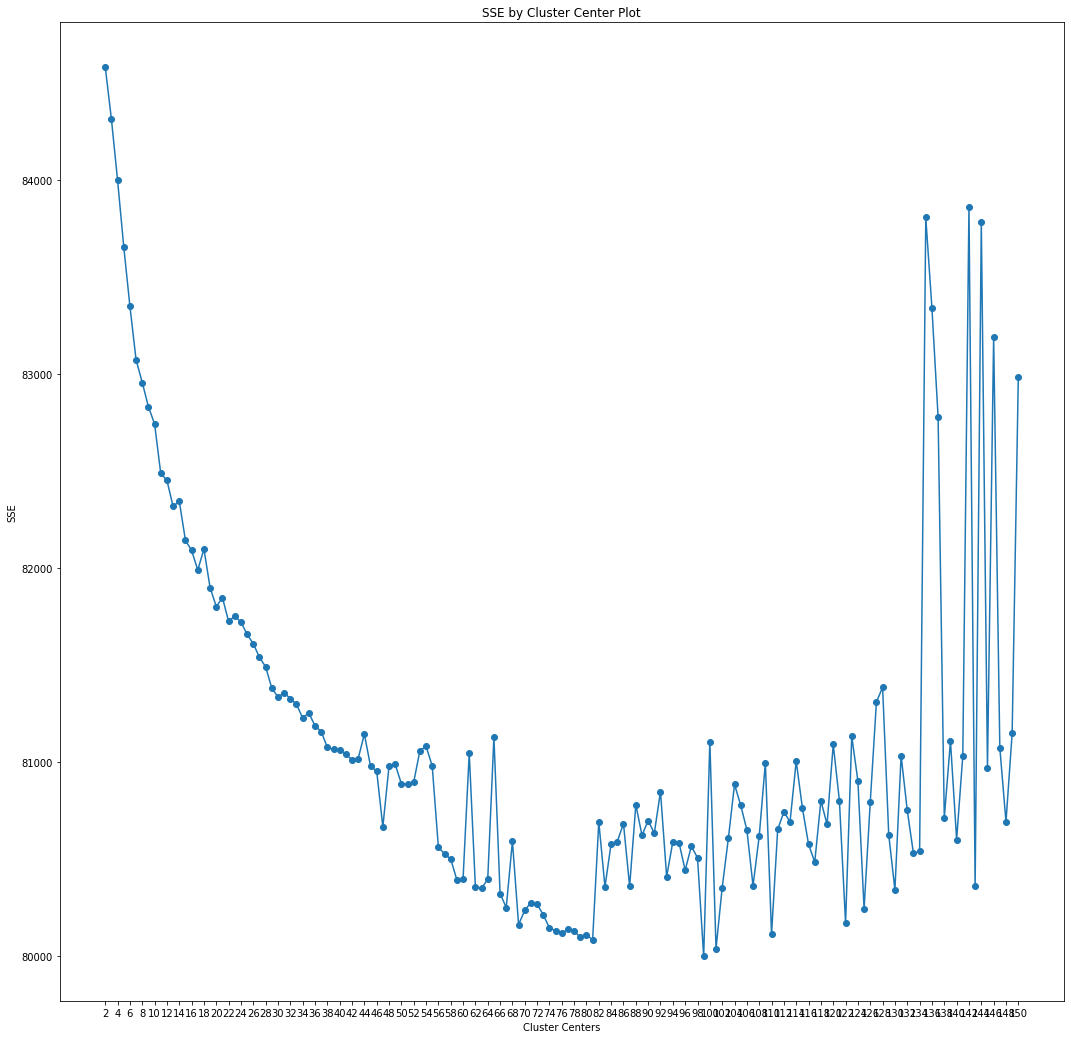

In [20]:
# Cluster analysis 
def find_optimal_clusters(data, min_k, max_k, num):
    iters = np.linspace(min_k, max_k, num = num).astype(int)
    
    sse = []
    for k in range(len(iters)):
        sse.append(cluster.MiniBatchKMeans(n_clusters = iters[k], init_size = 1024, batch_size = 2048, random_state = 42,
                                          reassignment_ratio = 0.01).fit(data).inertia_)
        if iters[k] % 25 == 0:
            print('Fit {} clusters'.format(iters[k].astype(int)))
            
    idx = np.where(sse == np.amin(sse))
    print(np.amin(sse), iters[idx])
          
    f, ax = plt.subplots(1, 1, figsize = (18, 18))
    #for n, label in enumerate(ax.xaxis.get_ticklabels()):
      #  if n % 10 != 0:
     #       label.set_visible(False)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters[np.where(iters % 2 == 0)])
    ax.set_xticklabels(iters[np.where(iters % 2 == 0)])
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 2, 150, 149)

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
# *Almost* the best amount of clusters given the elbow function
# evaluation shown above using mini-batch k-means
clusters = cluster.MiniBatchKMeans(n_clusters=43, init_size=1024, batch_size=2048, random_state=42).fit_predict(X_tfidf)

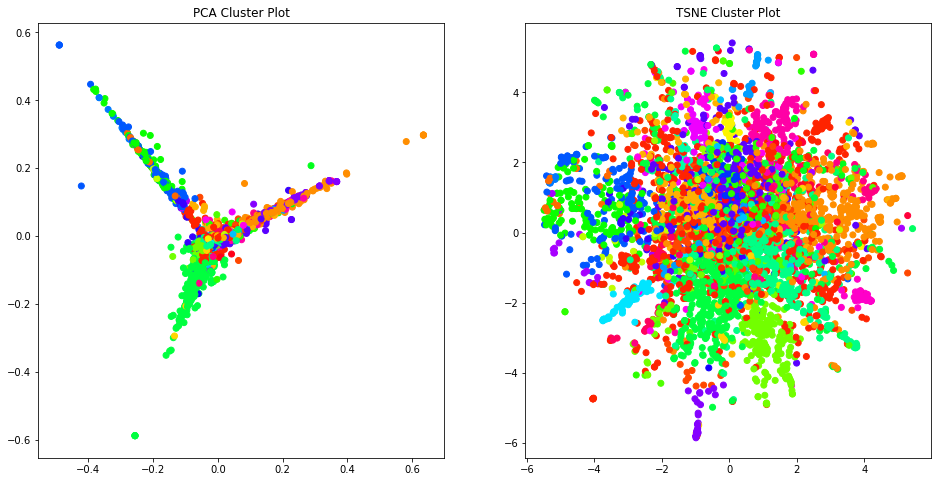

In [23]:
# Plotting the cluster analysis of gathered water tweets
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=10000, replace=False)
    
    pca = PCA(n_components=0.95).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=0.95).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=5000, replace=False)
    label_subset = labels[max_items]
    label_subset = [mpl.cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_tfidf, clusters)

Functions are similar to the ones found from Kaggle at this link: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans/comments

In [24]:
#This code is currently in markdown as it takes up way to much memory to show these results.

# What are the most common keywords in these clusters
# Takes up too much memory
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_tfidf, clusters, vectorizer.get_feature_names(), 30)



Cluster 0
roofs,brook,hydrocarbons,shld,firing,deliberate,po,inaction,lac,mower,juga,rotting,water,pollution,air,public,resources,power,natural,far,white,biggest,regulations,apparently,lands,debt,conserving,tearing,finances,loosening

Cluster 1
day,safe,good,going,today,groundwater,public,help,food,chemical,world,know,beach,health,watermanagement,need,com,new,drought,clean,people,like,flashflood,sanitation,pipe,leak,coli,drinking,contamination,water

Cluster 2
park,right,health,homes,bring,public,let,realdonaldtrump,want,need,lines,contamination,schools,high,poisoning,city,new,know,think,make,drink,levels,pipes,people,flint,like,drinking,horse,water,lead

Cluster 3
post,hwo,national,service,new,okx,nj,including,aug,pa,alert,effect,wv,oh,weather,county,ny,august,continues,issues,jul,nws,issued,watch,pm,warning,july,flash,flood,edt

Cluster 4
know,think,ya,sure,love,make,stop,lol,im,lot,bottle,hope,minding,better,really,people,lots,need,feel,today,start,good,clean,drink,eating,day,like,

| Cluster | Use? | Cluster | Use? |
| ------- | ---- | ------- | ---- |
| 0 | ? | 22 | |
| 1 | ? | 23 | |
| 2 | NO | 24 | |
| 3 | YES | 25 | |
| 4 | NO | 26 | |
| 5 | NO | 27 | |
| 6 | YES | 28 | |
| 7 | NO | 29 | |
| 8 | NO | 30 | |
| 9 | ? | 31 | |
| 10 | NO | 32 | |
| 11 | NO | 33 | |
| 12 | NO | 34 | |
| 13 | ? | 35 | |
| 14 | NO | 36 | |
| 15 | YES | 37 | |
| 16 | YES | 38 | |
| 17 | ? | 39 | |
| 18 | YES | 40 | |
| 19 | NO | 41 | |
| 20 | | 42 | |
| 21 | |

In [25]:
print(len(clusters))

85744


In [27]:
t_c = {'text': water_tweets, 'cleaned_text': np.array(water_csvs.cleaned_text), 'cluster': clusters}
water_tweet_cluster = pd.DataFrame(data = t_c)
water_tweet_cluster.head(25)

,text,cleaned_text,cluster
0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,its cwazy mom tiwed of seeing flash flood warn...,14
1,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,passes to flash flood water park in battle cre...,26
2,So the maintenance men at my apartment complex...,so the maintenance men at my apartment complex...,14
3,".@NWStulsa issued 1,530 flood/flash flood prod...",issued floodflash flood products in may alone ...,26
4,"They might not call it a #climatedebate, but c...",they might not call it a climatedebate but con...,26
5,*Flash Flood Warnings*\n*Extreme weather advis...,flash flood warnings extreme weather advisorie...,30
6,More info: https://t.co/HtkH9Or0b3 https://t.c...,more info,1
7,Very Dangerous Flash Flood | Natural Disaster ...,very dangerous flash flood natural disaster pu...,26
8,@Rnikz_ @JoahanYT he dead ass said #DareToAchi...,he dead ass said daretoachive after sending pr...,26
9,The 20 Democrats will meet this week in a Miam...,the democrats will meet this week in a miami p...,26


In [28]:
cluster_count = water_tweet_cluster.groupby('cluster').count().reset_index()
cluster_count = cluster_count.iloc[:, 1]
cluster_count.columns = ['count']
cluster_count

0         1
1     15237
2      4349
3       406
4      6739
5      5472
6       343
7       518
8         1
9       494
10      240
11     3917
12     2019
13     3145
14     2174
15      310
16     8674
17     1414
18     6980
19      507
20        1
21        1
22     1371
23      781
24     1159
25      235
26     2563
27     1586
28        1
29       13
30      632
31     5683
32     1021
33      316
34        1
35     1265
36      773
37      558
38     1891
39      861
40     1369
41      305
42      418
Name: text, dtype: int64

In [55]:
cluster_0 = water_tweet_cluster[water_tweet_cluster.cluster == 0]
cluster_0.head(10)

,text,tokenized,cluster
6,More info: https://t.co/HtkH9Or0b3 https://t.c...,[info],0
14,Beginning of this video shows Downtown Honolul...,"[beginning, video, shows, downtown, honolulu, ...",0
31,Working from Mae Chan firestation with local D...,"[working, mae, chan, firestation, local, dpm, ...",0
39,"@thehill June 25, 2019:\n\nhttps://t.co/TPGoYG...",[june],0
40,https://t.co/w4CrvFS3Qv,[],0
46,Follow the send crew down the Don Skjoli river...,"[follow, send, crew, skjoli, river, probably, ...",0
47,Follow the send crew down the Don Skjoli river...,"[follow, send, crew, skjoli, river, probably, ...",0
54,BRO issues Flash Flood Watch for Coastal Camer...,"[bro, issues, flash, flood, watch, coastal, ca...",0
62,Shared by Sylvia Jeanððð¯ ð©From Dis...,"[shared, sylvia, jean, discover, google]",0
66,HFO continues Flash Flood Watch for Central Oa...,"[hfo, continues, flash, flood, watch, central,...",0


In [29]:
dict_of_clusters = {k: v for k, v in water_tweet_cluster.groupby('cluster')}    

import pprint
pprint.pprint(dict_of_clusters)

{0:                                                    text  \
8389  *@ProgressShark Whiteness, apparently. \n\nNot...   

                                           cleaned_text  cluster  
8389  whiteness apparently not our countrys finances...        0  ,
 1:                                                     text  \
6      More info: https://t.co/HtkH9Or0b3 https://t.c...   
14     Beginning of this video shows Downtown Honolul...   
31     Working from Mae Chan firestation with local D...   
39     @thehill June 25, 2019:\n\nhttps://t.co/TPGoYG...   
40                               https://t.co/w4CrvFS3Qv   
...                                                  ...   
85688  Arizona House passes Drought Contingency Plan ...   
85705  It kind of got lost in the first half because ...   
85715  mbc gave us 5 songs to survive the 5 months dr...   
85729  Our bush kids, are the unsung heroes of this d...   
85736  I’m a huge fan of natural lawns.\n\nWhen I liv...   

                 

[861 rows x 3 columns],
 40:                                                     text  \
127    Cross contamination is gross ð·. If we could...   
142    World's most dangerous bioweapons\n\nHanta vir...   
245    ABCNEWS reports A northern Oklahoma town was w...   
255    A northern Oklahoma town was warned against co...   
259    @PatriciaThom10 @Skylar_Writer @meggggmarie Ra...   
...                                                  ...   
76662  Wood cutting boards are less likely to harbor ...   
79020  *@RepBarragan *@jordanwfisher_ I noticed that ...   
79479  *@DrShayPhD *@iveyjoan_usa No bacteria in the ...   
80077  *@coyoteboy *@SadiqKhan As I used to also thin...   
84200  And they dwelt with him for the priests and Ph...   

                                            cleaned_text  cluster  
127    cross contamination is gross if we could see b...       40  
142    worlds most dangerous bioweapons hanta virus f...       40  
245    abcnews reports a northern oklahoma tow

## Sub-cluster Analysis Used to Generate Relevant Data

In [57]:
cluster_0 = pd.DataFrame(data = dict_of_clusters[0])
cluster_1 = pd.DataFrame(data = dict_of_clusters[1])
cluster_3 = pd.DataFrame(data = dict_of_clusters[3])
cluster_6 = pd.DataFrame(data = dict_of_clusters[6])
cluster_9 = pd.DataFrame(data = dict_of_clusters[9])
cluster_13 = pd.DataFrame(data = dict_of_clusters[13])
cluster_15 = pd.DataFrame(data = dict_of_clusters[15])
cluster_16 = pd.DataFrame(data = dict_of_clusters[16])
cluster_18 = pd.DataFrame(data = dict_of_clusters[18])
cluster_18.head()

,text,tokenized,cluster
1554,Una de las âseÃ±alesâ del cambio climÃ¡tic...,"[una, de, las, seales, del, cambio, climtico, ...",18
1992,@ChiTownSports93 The LA kings ended a title dr...,"[la, kings, ended, title, drought, well]",18
2127,"*@Reuters Wow, omelette Ã la e-coli.","[wow, omelette, la, ecoli]",18
2137,*@mariogiordano5 Gente che probabilmente non Ã...,"[gente, che, probabilmente, non, mai, uscita, ...",18
2152,*@sninobecerra Ãs para comprobar mÃ¡s rÃ¡pido...,"[para, comprobar, ms, rpido, la, infeccin, por...",18


In [62]:
cluster_0_tfidf = vectorizer.fit_transform(np.array(cluster_0.tokenized).astype(str))
cluster_1_tfidf = vectorizer.fit_transform(str(cluster_1.tokenized))
cluster_3_tfidf = vectorizer.fit_transform(np.array(cluster_3.tokenized))
cluster_6_tfidf = vectorizer.fit_transform(np.array(cluster_6.tokenized))
cluster_9_tfidf = vectorizer.fit_transform(np.array(cluster_9.tokenized))
cluster_13_tfidf = vectorizer.fit_transform(np.array(cluster_13.tokenized))
cluster_15_tfidf = vectorizer.fit_transform(np.array(cluster_15.tokenized))
cluster_16_tfidf = vectorizer.fit_transform(np.array(cluster_16.tokenized))
cluster_18_tfidf = vectorizer.fit_transform(np.array(cluster_18.tokenized))

ValueError: setting an array element with a sequence

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
242.25573254507023 [20]


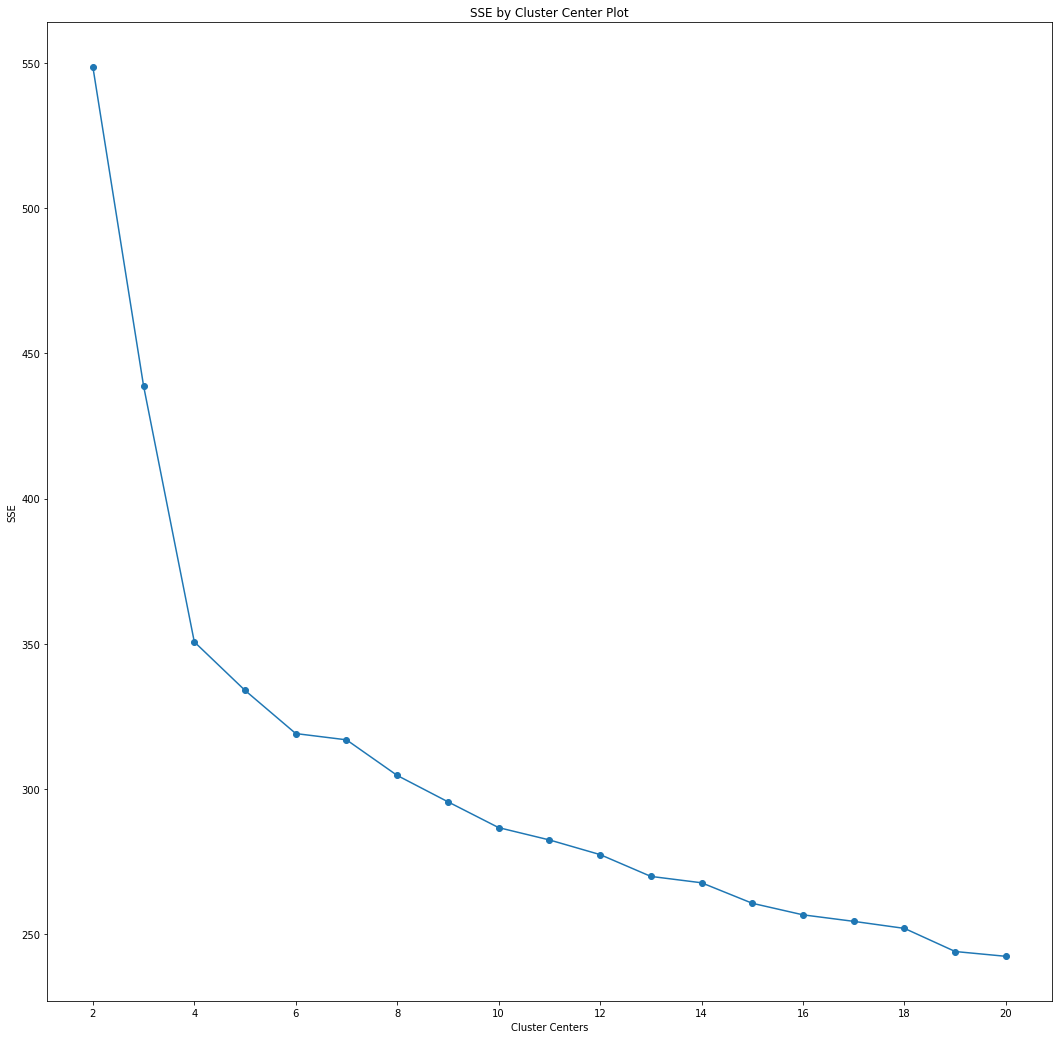

In [109]:
# Cluster analysis 
def find_optimal_clusters_kmeans(data, min_k, max_k, num):
    iters = np.linspace(min_k, max_k, num = num).astype(int)
    
    sse = []
    for k in range(len(iters)):
        sse.append(cluster.KMeans(n_clusters = iters[k], n_init = 25, random_state = 42, max_iter = 500).fit(data).inertia_)
        if iters[k] % 5 == 0:
            print('Fit {} clusters'.format(iters[k].astype(int)))
            
    idx = np.where(sse == np.amin(sse))
    print(np.amin(sse), iters[idx])
          
    f, ax = plt.subplots(1, 1, figsize = (18, 18))
    #for n, label in enumerate(ax.xaxis.get_ticklabels()):
      #  if n % 10 != 0:
     #       label.set_visible(False)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters[np.where(iters % 2 == 0)])
    ax.set_xticklabels(iters[np.where(iters % 2 == 0)])
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters_kmeans(cluster_4_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
6819.5854295352065 [20]


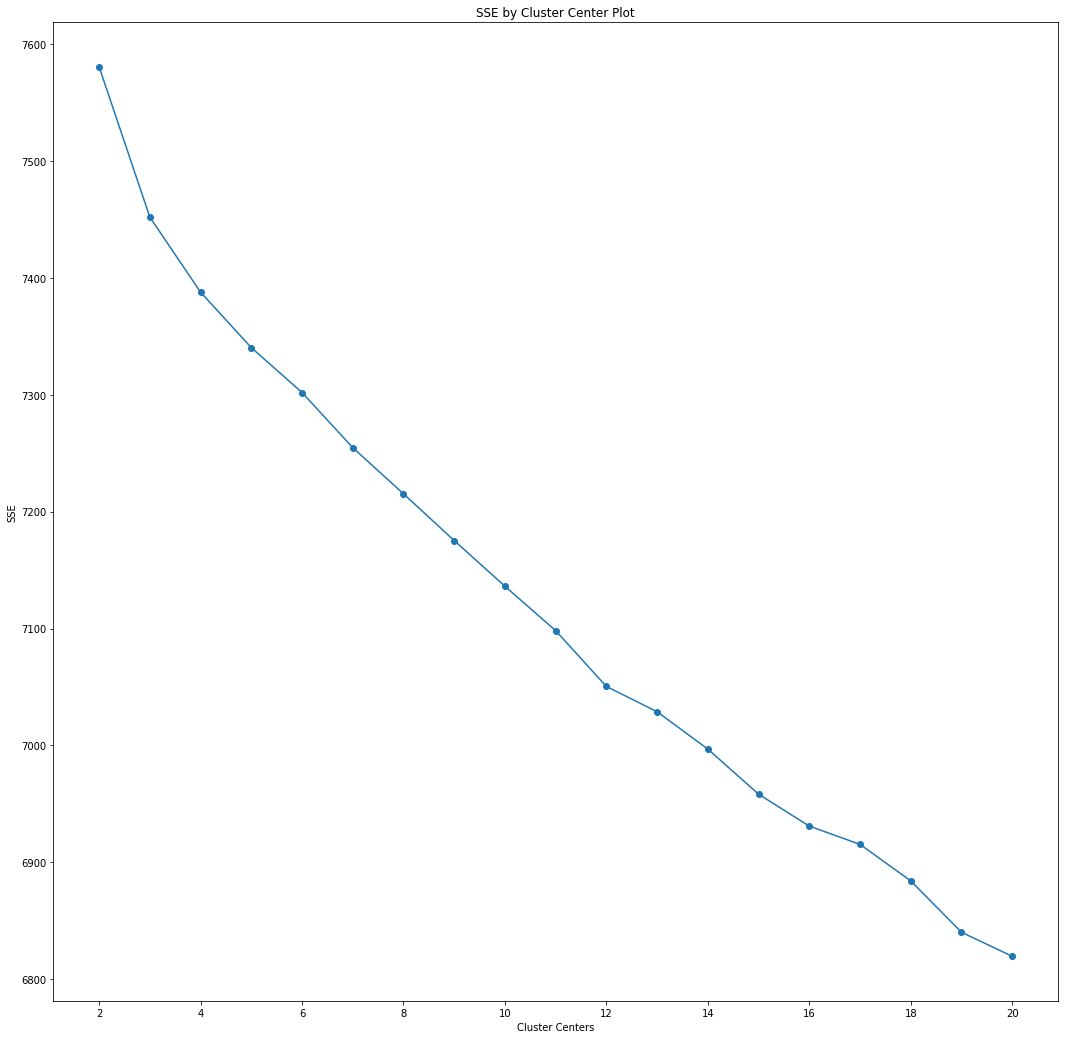

In [110]:
find_optimal_clusters_kmeans(cluster_5_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
4400.621817190622 [20]


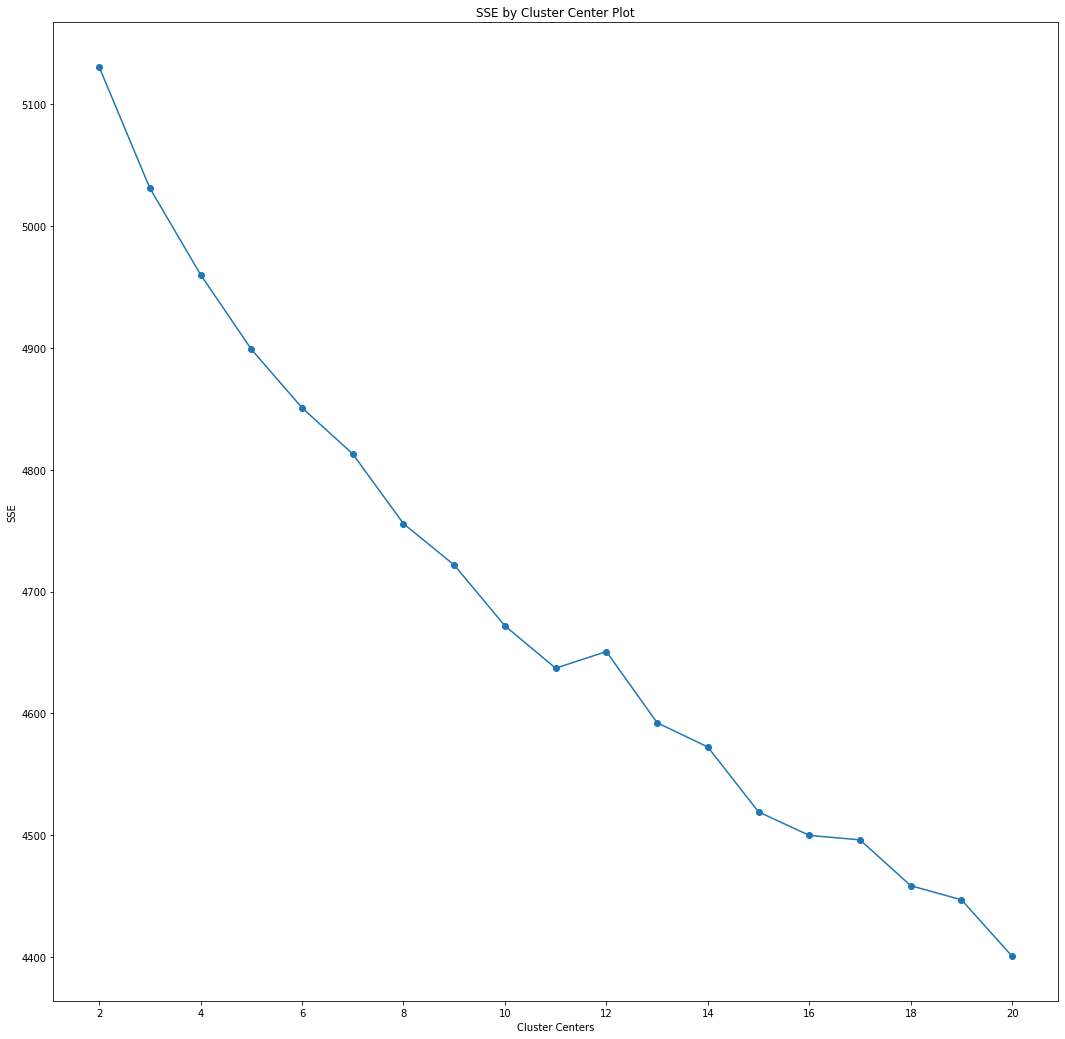

In [45]:
find_optimal_clusters_kmeans(cluster_6_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
36930.74773603208 [20]


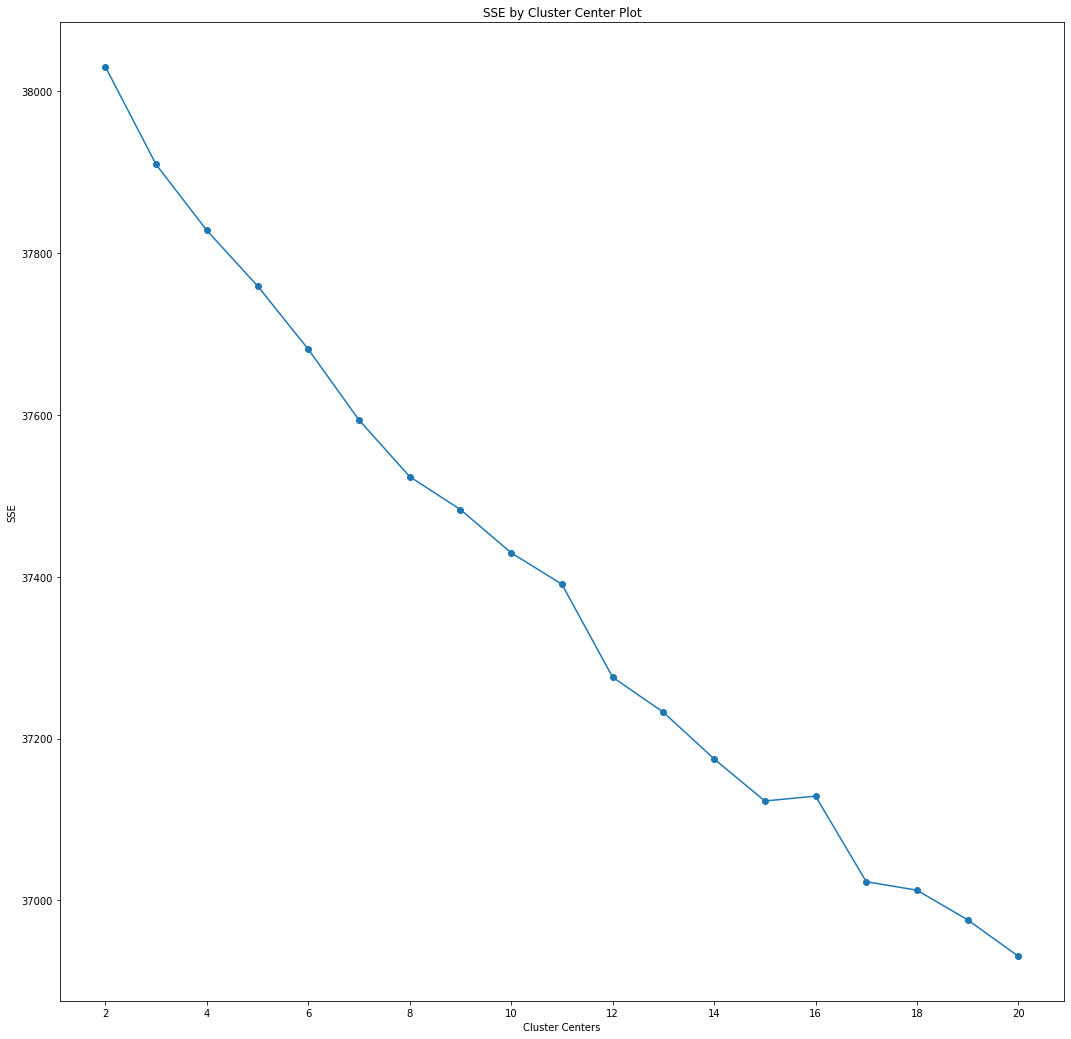

In [46]:
find_optimal_clusters_kmeans(cluster_7_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
2589.617220498784 [20]


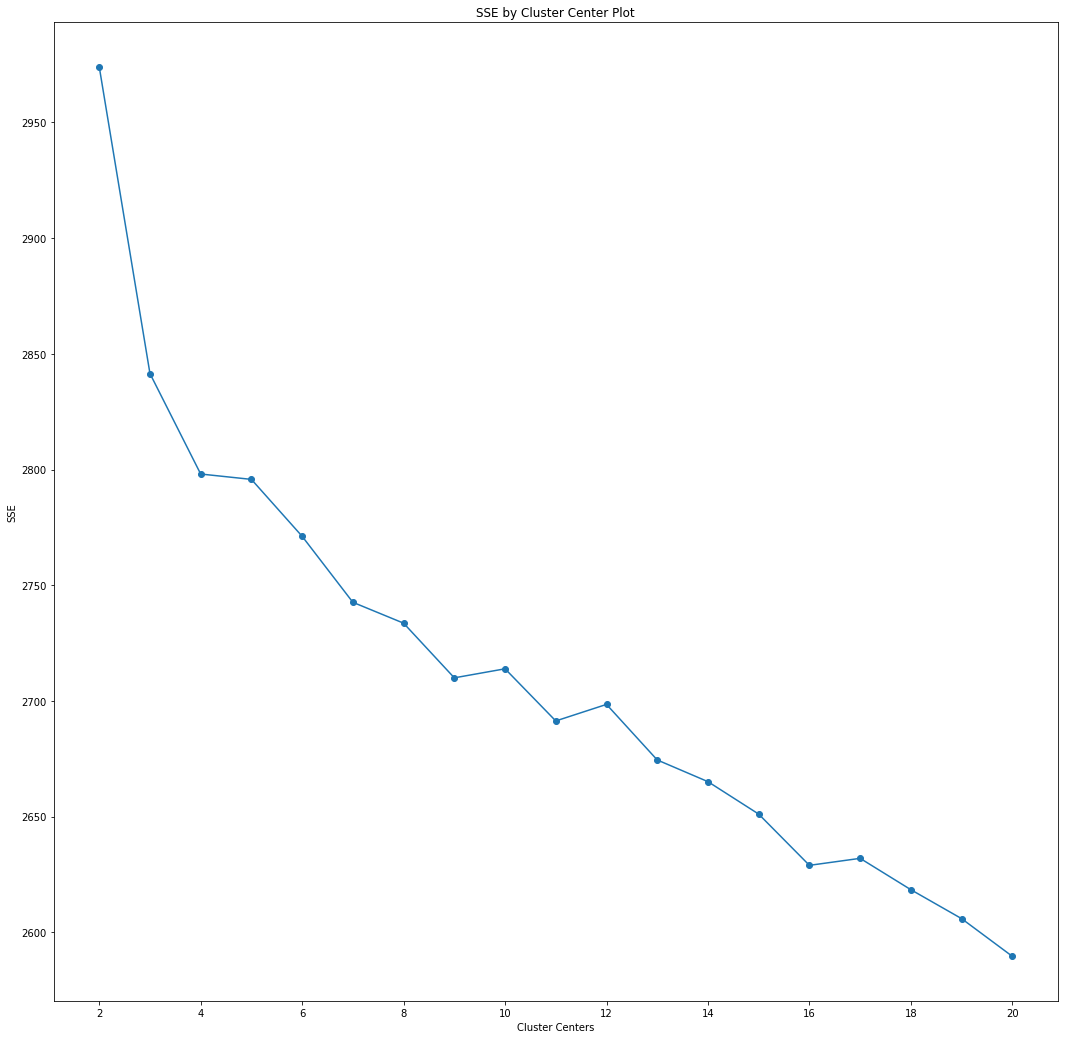

In [47]:
find_optimal_clusters_kmeans(cluster_8_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
485.4968565704416 [20]


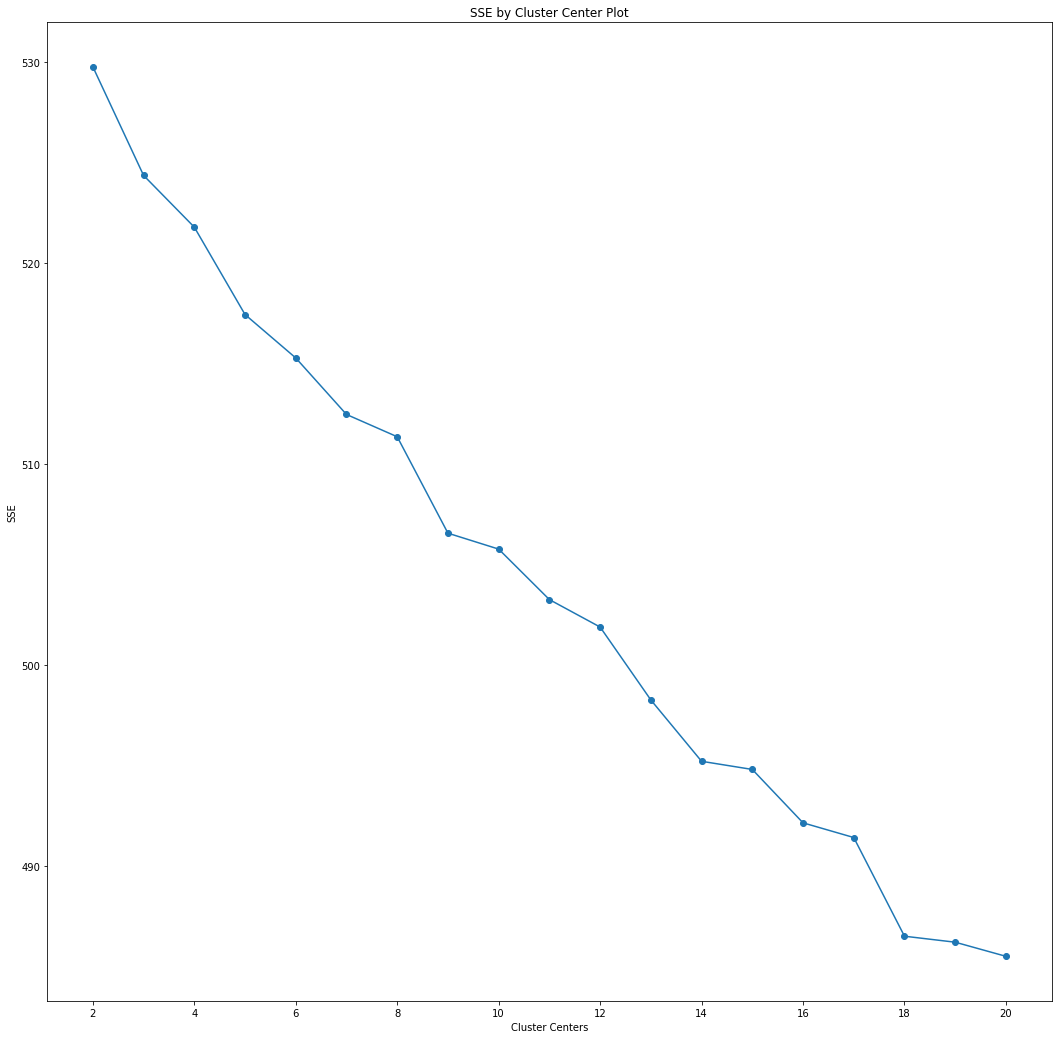

In [48]:
find_optimal_clusters_kmeans(cluster_9_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
1338.3591120322085 [20]


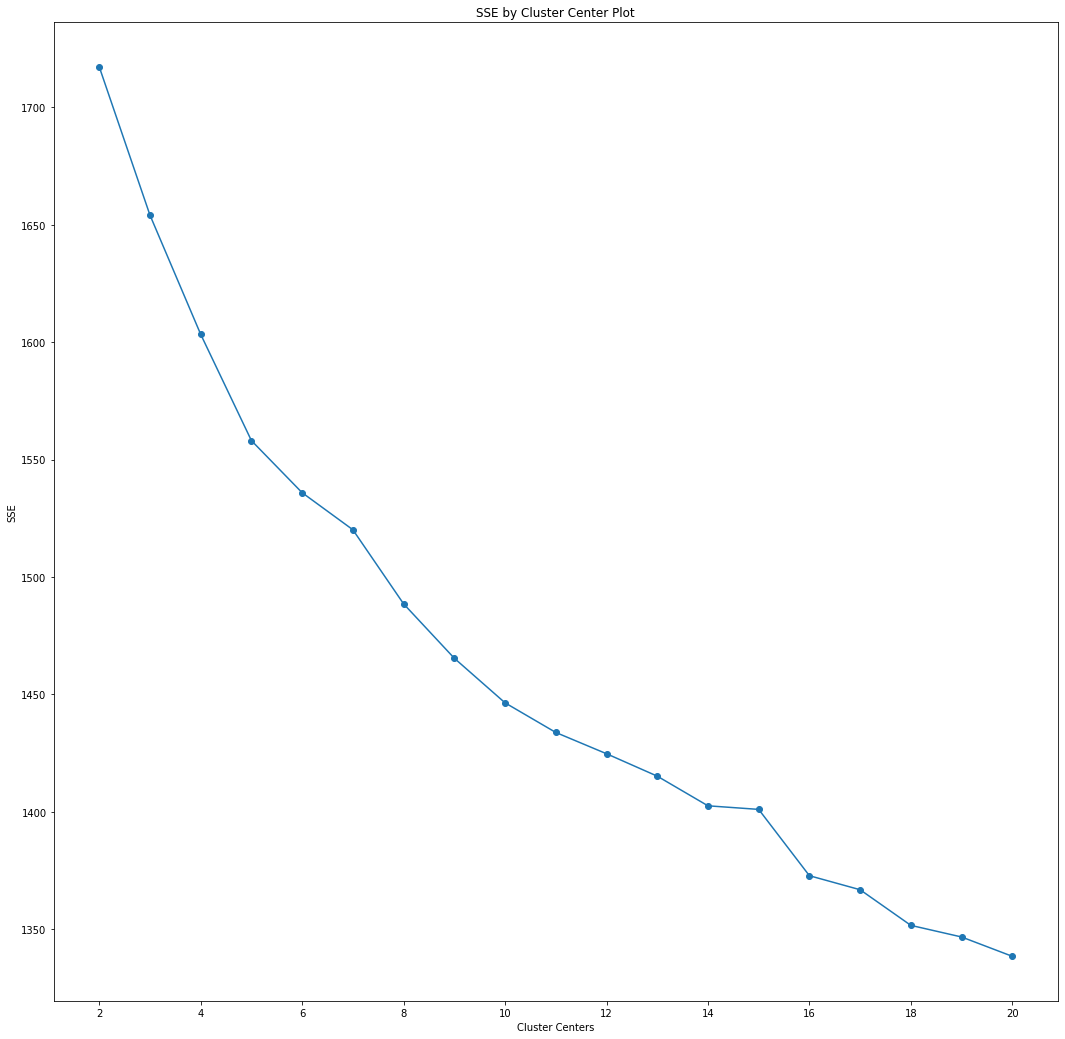

In [49]:
find_optimal_clusters_kmeans(cluster_10_tfidf, 2, 20, 19)

Fit 5 clusters
Fit 10 clusters
Fit 15 clusters
Fit 20 clusters
9761.056047963859 [19]


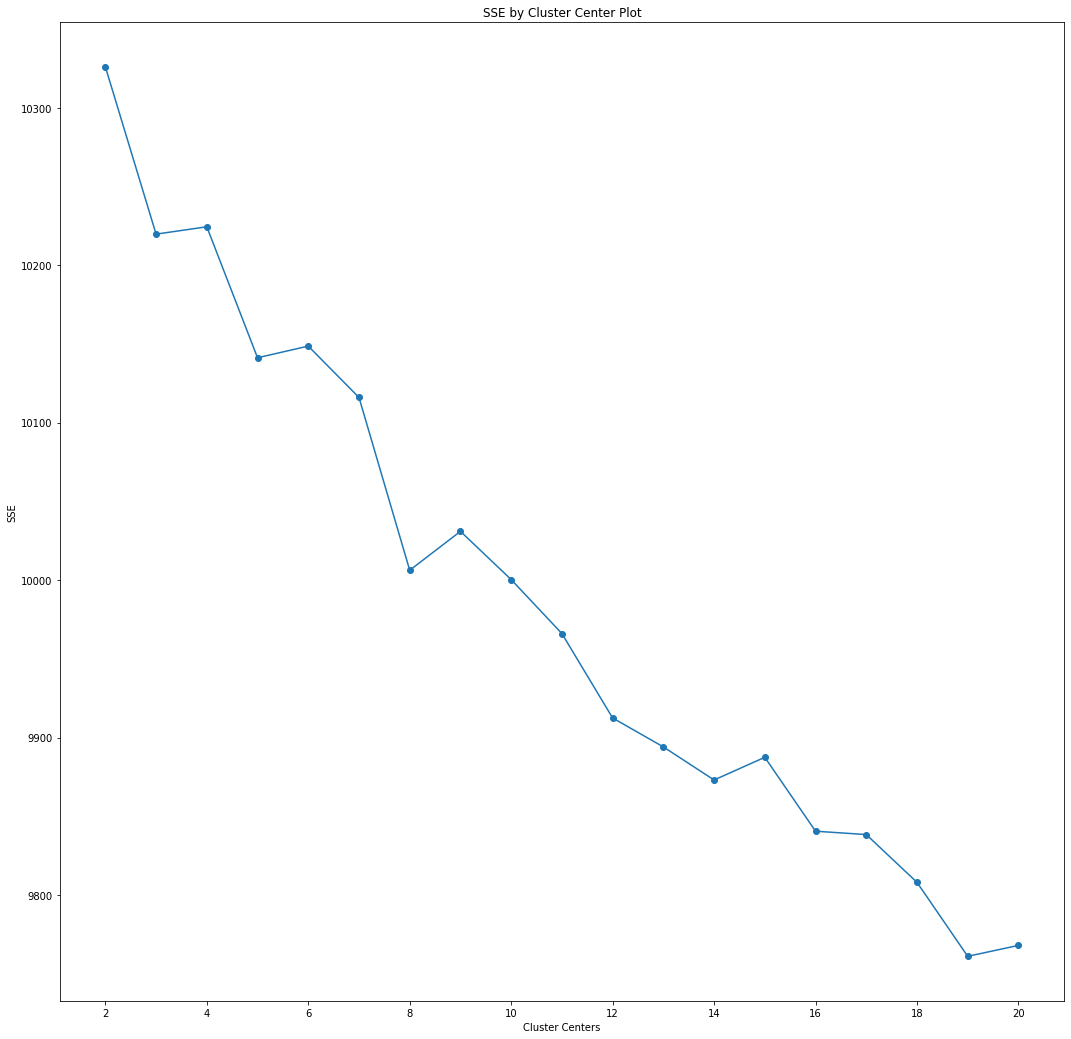

In [50]:
find_optimal_clusters_kmeans(cluster_13_tfidf, 2, 20, 19)

Okay, so we want to use 4 or 6 clusters for cluster 4, __ clusters for cluster 5, 11 clusters for cluster 6, 15 clusters for cluster 7, 4 clusters for cluster 8, 15 clusters for cluster 9, 14 clusters for cluster 10, and 8 for cluster 13.

### Optimal Number of Clusters
We will analyze the "optimal clusterings".

In [67]:
clusters_4 = cluster.KMeans(n_clusters = 6, n_init = 25, random_state = 42, max_iter = 500).fit(cluster_4_tfidf).labels_

In [113]:
clusters_5 = cluster.KMeans(n_clusters = 12, n_init = 25, random_state = 42, max_iter = 500).fit(cluster_5_tfidf).labels_

In [70]:
clusters_6 = cluster.KMeans(n_clusters = 11, n_init = 25, random_state = 42, max_iter = 500).fit(cluster_6_tfidf).labels_

In [71]:
clusters_7 = cluster.KMeans(n_clusters = 15, n_init = 25, random_state = 42, max_iter = 500). fit(cluster_7_tfidf).labels_

In [84]:
clusters_8 = cluster.KMeans(n_clusters = 6, n_init = 25, random_state = 42, max_iter = 500). fit(cluster_8_tfidf).labels_

In [73]:
clusters_9 = cluster.KMeans(n_clusters = 15, n_init = 25, random_state = 42, max_iter = 500). fit(cluster_9_tfidf).labels_

In [74]:
clusters_10 = cluster.KMeans(n_clusters = 14, n_init = 25, random_state = 42, max_iter = 500). fit(cluster_10_tfidf).labels_

In [75]:
clusters_13 = cluster.KMeans(n_clusters = 8, n_init = 25, random_state = 42, max_iter = 500). fit(cluster_13_tfidf).labels_

### Figure out which subclusters are useful

In [114]:
cluster_4['subcluster'] = clusters_4
cluster_5['subcluster'] = clusters_5
cluster_6['subcluster'] = clusters_6
cluster_7['subcluster'] = clusters_7
cluster_8['subcluster'] = clusters_8
cluster_9['subcluster'] = clusters_9
cluster_10['subcluster'] = clusters_10
cluster_13['subcluster'] = clusters_13

In [77]:
cluster_4

,text,cluster,subcluster
6,More info: https://t.co/HtkH9Or0b3 https://t.c...,4,5
41,https://t.co/w4CrvFS3Qv,4,1
122,https://t.co/KydHXaMTVT,4,1
240,"@anildash Corporations lie, and local governme...",4,5
293,#GiveEcoliATail https://t.co/ClsTyuH9q0,4,1
315,Letter: Water Contamination On Long Island htt...,4,3
333,@Kre8change https://t.co/7iBPlT3b7g,4,1
375,Letter: Water Contamination On Long Island htt...,4,3
405,#contamination #waterpollution https://t.co/OH...,4,5
413,Letter: Water Contamination On Long Island htt...,4,3


In [115]:
cluster_5

,text,cluster,subcluster
0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,5,4
1,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,5,4
2,So the maintenance men at my apartment complex...,5,4
3,".@NWStulsa issued 1,530 flood/flash flood prod...",5,4
4,"They might not call it a #climatedebate, but c...",5,4
5,*Flash Flood Warnings*\n*Extreme weather advis...,5,4
7,Very Dangerous Flash Flood | Natural Disaster ...,5,4
8,@Rnikz_ @JoahanYT he dead ass said #DareToAchi...,5,4
10,Our #SummerSavingsGiveaway continues! Starting...,5,4
11,Please keep us in your prayers as we will be r...,5,4


In [78]:
cluster_6

,text,cluster,subcluster
479,Yemeni Co for investment in oil &amp; minerals...,6,9
736,@FabulouslyIndie Does your coconut oil contain...,6,9
4004,Solomon Islands: bay hit by oil spill suffers ...,6,9
6037,âMy hair looks dryâ\n*sprays Moroccan oil*...,6,9
6186,*@ObelwaKgosigadi Bio oil / celltone oil / gen...,6,9
6841,Global Oil and Gas Pipeline Leak Detection Equ...,6,9
8326,The Trump team has been sued for groundwater c...,6,9
8551,".*@Chevron has dumped 800,000 gallons of crude...",6,8
8942,"""Oil and gas infrastructure will never be free...",6,9
9274,https://t.co/t9iroQIyzR Damping of surface wav...,6,9


In [79]:
cluster_7

,text,cluster,subcluster
9,The 20 Democrats will meet this week in a Miam...,7,6
13,Get ready for thunderstorms and flash floods t...,7,6
14,Beginning of this video shows Downtown Honolul...,7,6
17,Get ready for thunderstorms and flash floods t...,7,6
27,The enhanced risk is still in place but has sh...,7,6
28,The enhanced risk is still in place but has sh...,7,6
40,"@thehill June 25, 2019:\n\nhttps://t.co/TPGoYG...",7,6
42,FMFD has joined agencies from across the regio...,7,6
46,@HendoYankees @davidtabrown Dave once saved 30...,7,6
47,Follow the send crew down the Don Skjoli river...,7,6


In [86]:
cluster_8

,text,cluster,subcluster
149,@FLOTUS What about the #KidsInCages? What abou...,8,0
300,People in University Park still can't drink or...,8,0
344,Meeting held to address lead contamination in ...,8,0
360,Ninty percent of Flint water samples had 4 par...,8,0
363,Chicago (IL) WLS: Meeting to be held to addres...,8,0
367,Meeting to be held to address lead contaminati...,8,0
371,University Park residents will have a chance t...,8,0
425,@MichiganLCV A new and improved lead/copper ru...,8,0
426,University Park's mayor said he declared a sta...,8,0
2467,"I suggest this person use a dictionary, accomm...",8,0


In [81]:
cluster_9

,text,cluster,subcluster
284,@Ssimms777 @KeWeiss1 @MelissaFazli @GavinNewso...,9,7
2096,*@noahcicero *@DaisyFried Coal ash ponds are t...,9,8
2097,"""NC wants to find the source of water contamin...",9,11
2098,*@atrupar Making great progress?\n you're doin...,9,10
2099,"As if we needed more reasons to ditch coal, it...",9,12
2100,*@shossy2 *@RodneyClaeys W/ Obama's restrictio...,9,0
2101,NC wants to find the source of water contamina...,9,11
2102,NC wants to find the source of water contamina...,9,11
2103,Mike Pence is lying to us daily. He doesn't b...,9,8
2104,â¦â¦*@VPâ© stupid and short-sighted. Coal i...,9,10


In [82]:
cluster_10

,text,cluster,subcluster
3858,NOTE: this contamination was acute &amp delib...,10,6
8014,NOTE: this contamination was acute &amp; delib...,10,6
8204,A long season of heavy rains has researchers f...,10,8
8219,Satellite Imagery Confirms Factory Farm Growth...,10,8
8511,"âThat's your president, America.\n\nIt's got...",10,6
9405,Bloom's Mission to Turn Toxic Algae into Shoes...,10,4
9406,Algae bloom in Lake Chivero today. #ZimbabweWa...,10,6
9407,Bloom's Mission to Turn Toxic Algae into Shoes...,10,4
9408,"Hurricane Barry, Was It Manipulated In The Att...",10,6
9409,Bloom's Mission to Turn Toxic Algae into Shoes...,10,4


In [83]:
cluster_13

,text,cluster,subcluster
1167,@soodsaab08 @capbunnykiller @NetflixIndia Wate...,13,3
1523,Hereâs your regular plug to read âThe Swam...,13,1
1599,Two service providers in the #ACT rescuing foo...,13,7
1600,Yeah fun fact: This is the imbecile who - as G...,13,3
1601,OH SEHUN THANK YOU FOR SAVING THIS DROUGHT,13,7
1603,Chinese agriculture minister to head UN food a...,13,7
1606,Lots to discuss about #cawater at the 2019 Wat...,13,1
1608,"@Tshoki_Moses How's drought that side, ke batl...",13,7
1611,The pattern has been gang busters in one game ...,13,7
1612,I got a new plug it ainât a drought no more ...,13,1


In [89]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        
        
get_top_keywords(cluster_4_tfidf, clusters_4, vectorizer.get_feature_names(), 15)


Cluster 0
waterislife,watersolutions,cleanwaterforall,waterquality,accessiblewater,watersystems,waterequipment,chemrock,mactanrock,waterrific,watersupply,drinkingwater,watertechnology,waterprovider,waterservices

Cluster 1
foolhardy,httptcoaxclkupl…,weakest,contender,loathe,burnham,laborista,slashed,aloud,years,html,donations,14,contd,https

Cluster 2
smartnews,fun,climatechangeisreal,environment,don,huffpost,https,sand,sun,sewage,report,shows,beaches,unsafe,swimming

Cluster 3
slashed,charisma,influx,thrones,weakest,warning,coli,addressing,beach,https,water,island,letter,long,contamination

Cluster 4
depends,ve,kidding,said,watermanagement,sewage,ia,persons,imagine,dog,cat,management,https,water,drinking

Cluster 5
waste,a1,coli,ecosearch,web,environment,pollution,ecoli,news,management,wastewater,flashflood,waterpollution,water,https


In [116]:
get_top_keywords(cluster_5_tfidf, clusters_5, vectorizer.get_feature_names(), 15)


Cluster 0
valid,https,updates,pm,mo,watch,time,extends,16,till,jul,cdt,continues,00,areas

Cluster 1
cdt,10,flood,2019,warning,05,notice,view,statement,07,nws,06,issued,edt,august

Cluster 2
aug,45,cdt,continues,15,flood,flash,https,00,warning,pm,edt,issues,jul,till

Cluster 3
00,till,colfax,sandoval,continues,flood,30,flash,https,including,warning,pm,abq,nm,mdt

Cluster 4
counties,heavy,amp,barry,effect,watch,issued,area,warnings,flooding,rain,warning,https,flood,flash

Cluster 5
flooded,portions,doppler,roadways,lawx,low,rising,rivers,waters,look,aware,lying,avoid,acadiana,bayous

Cluster 6
effect,locations,entire,following,tuesday,fios1news,info,portions,weather,issued,area,flood,flash,https,watch

Cluster 7
new,18,17,post,https,16,flood,23,flash,watch,edt,issued,cdt,nws,july

Cluster 8
jasper,jones,pm,flash,flood,14,https,warning,issues,15,till,jul,cdt,jan,ms

Cluster 9
45,flood,twc,flash,till,pima,yavapai,https,30,fgz,gila,warning,pm,mst,az

Cluster 10
sunday,monday,effect,arwx,w

In [90]:
get_top_keywords(cluster_6_tfidf, clusters_6, vectorizer.get_feature_names(), 15)


Cluster 0
spill,island,pristine,oil,remote,liters,https,000,litres,diesel,spilled,sea,patagonia,chile,40

Cluster 1
country,spill,oil,locals,brings,anger,https,biggest,decades,defiance,chevron,canyon,ordered,halt,california

Cluster 2
owned,launch,harming,demanding,500,disastrous,write,sunken,administrator,wheeler,gulf,mexico,epa,energy,taylor

Cluster 3
nlpoli,canada,cdnpoli,https,oil,news,000,cbc,spilled,rig,ocean,12,newfoundland,causing,shutdown

Cluster 4
plugging,oil,spill,news,coast,patagonian,reported,navy,southern,island,investigating,https,remote,says,chilean

Cluster 5
atlanta,treated,university,evacuated,clark,place,shelter,east,rutherford,like,cause,style,https,spill,chemical

Cluster 6
action,graves,ecowatch,oil,spill,https,pristine,hit,care2,dead,larger,indonesian,ravages,paris,island

Cluster 7
litre,suspends,cbc,12,spill,oil,news,newfoundland,https,halts,canada,shut,production,platform,hibernia

Cluster 8
dumps,nearly,crude,oil,https,california,county,kern,spills,canyo

In [91]:
get_top_keywords(cluster_7_tfidf, clusters_7, vectorizer.get_feature_names(), 15)


Cluster 0
75,flexible,hybrid,giraffe,x3,water,https,drinking,safe,heavy,garden,duty,lightweight,hose,flexzilla

Cluster 1
going,having,eating,management,ve,amp,good,today,gallon,like,drink,https,water,drinking,day

Cluster 2
skin,cars,houses,businesses,clothes,public,going,sheets,spill,chemical,nh,2013,nashua,world,went

Cluster 3
conservation,better,poor,emergency,project,sustainable,flood,resource,waste,india,resources,amp,https,water,management

Cluster 4
lead,military,50,revealed,london,locations,fountains,amp,york,contamination,drinking,management,water,https,new

Cluster 5
bacteria,sites,today,enquirer,ohio,58,usa,water,https,usatoday,list,beaches,america,poop,dirtiest

Cluster 6
beach,clean,flood,people,like,amp,flashflood,waste,pipe,leak,ecoli,sewage,sanitation,water,https

Cluster 7
city,ordered,contamination,levels,boil,flour,recalled,cdc,la,ground,linked,outbreak,bison,https,coli

Cluster 8
migrant,reports,kids,300,caring,remote,station,patrol,detained,inadequate,texas,sani

In [93]:
get_top_keywords(cluster_8_tfidf, clusters_8, vectorizer.get_feature_names(), 15)


Cluster 0
new,contamination,amp,make,people,like,pipes,levels,flint,drink,drinking,horse,https,lead,water

Cluster 1
old,want,thirsty,ita,https,force,saying,think,em,lead,water,cana,horse,drink,make

Cluster 2
laborista,amidst,michigan,problems,crazy,post,washington,lead,https,flint,state,blood,emergency,mich,declared

Cluster 3
problem,potus,ya,say,think,ita,force,em,https,cana,lead,water,drink,make,horse

Cluster 4
just,mad,didnt,marcorubio,das,2a,sumn,yu,thats,ya,sum,lead,water,cana,bring

Cluster 5
dioxide,speed,circumstances,naturally,occurring,study,researchers,toa,lead,water,https,maybe,lots,blame,manganese


In [94]:
get_top_keywords(cluster_9_tfidf, clusters_9, vectorizer.get_feature_names(), 15)


Cluster 0
poison,mercury,states,realdonaldtrump,people,epa,toxic,air,gop,https,vote,ash,coal,water,amp

Cluster 1
insideclimate,coalash,inside,news,coal,ash,https,trump,epa,rules,use,sites,construction,proposes,weaker

Cluster 2
country,streams,climatechange,poor,contamination,gop,guess,wea,ve,https,stop,ita,ash,coal,water

Cluster 3
advocates,ash,deq,coal,county,site,investigation,orders,chatham,ohio,river,https,contamination,ponds,groundwater

Cluster 4
humans,ash,tribune,chicago,https,coal,pollution,groundwater,rules,plant,illinois,polluted,board,waukegan,lakefront

Cluster 5
coal,lifting,epa,health,proposed,filled,supply,burning,leach,hazardous,left,residue,problems,cause,substances

Cluster 6
streams,better,toxic,waste,good,does,allowing,companies,make,drink,ash,coal,foxandfriends,realdonaldtrump,water

Cluster 7
food,coal,removing,causes,stopped,wake,friend,concern,rich,real,polluting,america,industry,needs,cancer

Cluster 8
dump,dumped,air,protect,rivers,pollution,toxic,drinkin

In [95]:
get_top_keywords(cluster_10_tfidf, clusters_10, vectorizer.get_feature_names(), 15)


Cluster 0
gulf,mexico,fare,quartz,affect,bloom,algae,good,https,worse,make,bad,barry,storm,tropical

Cluster 1
skiing,pennington,warns,coos,beaches,state,algae,bloom,mercer,possible,https,county,lake,toxic,closes

Cluster 2
new,times,york,nyt,anne,barnard,algae,bloom,https,lake,largest,broader,crisis,indicating,fouls

Cluster 3
loathe,nasa,effects,man,geoengineering,lakeerie,algae,bloom,https,lake,toxic,erie,green,turning,expands

Cluster 4
news,climatechange,habs,automated,founders,algae,bloom,online,outside,https,toxic,outsidemagazine,turn,mission,shoes

Cluster 5
blue,green,smithfield,toxic,algae,bloom,https,responsible,death,kills,vermont,puppy,private,dog,pond

Cluster 6
mississippi,officials,state,swimming,harmful,gulf,advisory,blue,toxic,green,water,lake,bloom,https,algae

Cluster 7
forces,blue,bans,swimming,bloom,coast,algae,close,21,toxic,https,gulf,closed,beaches,mississippi

Cluster 8
predicted,forecast,western,seen,rapidly,expanding,expected,summer,imagery,bloom,algae,http

In [96]:
get_top_keywords(cluster_13_tfidf, clusters_13, vectorizer.get_feature_names(), 15)


Cluster 0
kno,trap,rich,album,got,colossal,purple,future,talk,stick,1future,genius,drought,https,thought

Cluster 1
australia,chennai,change,india,2019,france,sudan,million,climatechange,south,climate,love,water,drought,https

Cluster 2
ramsey,foolhardy,weakest,contender,loathe,burnham,laborista,slashed,charisma,influx,httptcoaxclkupl…,coming,survive,https,drought

Cluster 3
thunderstorm,farmers,year,pray,day,disappointing,weather,useless,forecast,blessed,like,https,drought,waiting,rain

Cluster 4
selca,years,end,ended,taekook,https,people,like,ya,good,drought,games,playing,loyalty,finally

Cluster 5
environment,watch,water,watershortage,india,chennaiwatercrisis,youtube,drought,news,bbc,https,chennai,city,space,visible

Cluster 6
tsunami,andaman,cyclone,gujarat,islands,ladakh,nicobar,volunteers,earthquake,leh,gave,aa,1a,rajasthan,mishaps

Cluster 7
going,com,real,climate,long,water,years,end,ia,amp,http,like,year,https,drought


### Relevant List:
__Using my best judgment from the most common keywords for each subcluster, these are the cluster-subcluster that contain relevant tweets. If we start picking up irrelevant stuff, this is where we will hope our active learning strategy will take over.__

Cluster 4; Subcluster 2

Cluster 6; Subclusters 0, 1, 3, 4, 7, 8, 9

Cluster 7; Subclusters 5, 6, 12 

Cluster 8; Subclusters 5

Cluster 9; Subclusters 3, 4, 14

Cluster 10; Subclusters 0, 1, 3, 5, 6, 7, 8, 10, 11, 12

Cluster 13; Subclusters 1, 5, 6

In [119]:
# Add cluster 5
relevant_tweets = pd.concat([cluster_4[cluster_4.subcluster == 2], cluster_5, cluster_6[cluster_6.subcluster == 0],
                            cluster_6[cluster_6.subcluster == 1], cluster_6[cluster_6.subcluster == 3],
                            cluster_6[cluster_6.subcluster == 4], cluster_6[cluster_6.subcluster == 7],
                            cluster_6[cluster_6.subcluster == 8], cluster_6[cluster_6.subcluster == 9],
                            cluster_7[cluster_7.subcluster == 5], cluster_7[cluster_7.subcluster == 6],
                            cluster_7[cluster_7.subcluster == 12], cluster_8[cluster_8.subcluster == 5],
                            cluster_9[cluster_9.subcluster == 3], cluster_9[cluster_9.subcluster == 4],
                            cluster_9[cluster_9.subcluster == 14], cluster_10[cluster_10.subcluster == 0],
                            cluster_10[cluster_10.subcluster == 1], cluster_10[cluster_10.subcluster == 3],
                            cluster_10[cluster_10.subcluster == 5], cluster_10[cluster_10.subcluster == 6],
                            cluster_10[cluster_10.subcluster == 7], cluster_10[cluster_10.subcluster == 8],
                            cluster_10[cluster_10.subcluster == 10], cluster_10[cluster_10.subcluster == 11],
                            cluster_10[cluster_10.subcluster == 12], cluster_13[cluster_13.subcluster == 1],
                            cluster_13[cluster_13.subcluster == 5], cluster_13[cluster_13.subcluster == 6]])
relevant_tweets.drop_duplicates(subset = ['text']).reset_index()
print(len(relevant_tweets))
relevant_tweets.head()

33523


,text,cluster,subcluster
3547,"Sun, Sand And Sewage: Report Shows Many U.S. B...",4,2
3548,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",4,2
3551,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",4,2
3554,"Sun, Sand And Sewage: Report Shows Many U.S. B...",4,2
3561,"Sun, Sand And Sewage: Report Shows Many U.S. B...",4,2


In [120]:
from pandas import HDFStore
relevant_tweets.to_hdf('relevant_tweets.h5', key = 'relevant_tweets')

In [10]:
rnd_csvs = rnd_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
rnd_csvs = rnd_csvs.iloc[:, 2:]

In [11]:
rnd_csvs.head()

,category,date,text,retweet_count,tweet_id
0,the,7/18/2019 23:38,If you do the Jeep wave Iâm cutting your fin...,0,1.152000e+18
1,the,7/18/2019 23:38,*@pokelover941 *@PoGoMaster5000 *@Kelven91 To ...,0,1.152000e+18
2,the,7/18/2019 23:38,I actually went to the gym during the day who ...,0,1.152000e+18
3,the,7/18/2019 23:38,*@PralineQueen1 I am quite looking forward to ...,0,1.152000e+18
4,the,7/18/2019 23:38,*@CoryBooker Is it possible said officer was l...,0,1.152000e+18


In [13]:
rnd_sample = rnd_csvs.sample(n = 36477, replace = False, random_state = 42)
rnd_sample.to_hdf('not_relevant_tweets.h5', key = 'not_relevant_tweets')